In [331]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
%matplotlib inline

## Import data

In [332]:
df = pd.read_csv('auto-mpg.csv', delimiter=';')

In [333]:
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_model
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,"\t""chevrolet chevelle malibu"""
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,"\t""buick skylark 320"""
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,"\t""plymouth satellite"""
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,"\t""amc rebel sst"""
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,"\t""ford torino"""


In [334]:
df.drop(['car_model'], axis=1, inplace=True)

In [335]:
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


## Task: predict mpg

## Data preprocessing

In [336]:
df = df.replace('?', np.nan)

In [337]:
# Дивимось в якій колонці є nan
columns = df.columns

for column in columns:
    print(column)
    print(any(df[column].isna()))
    print('---------------------')

mpg
False
---------------------
cylinders
False
---------------------
displacement
False
---------------------
horsepower
True
---------------------
weight
False
---------------------
acceleration
False
---------------------
model_year
False
---------------------
origin
False
---------------------


In [364]:
# замінюємо nan на середнє значення по колонці
df['horsepower'] = df['horsepower'].astype(np.float64)
df['horsepower'].fillna(df['horsepower'].mean(), inplace=True)

# Visualization

### Hist for "acceleration" column

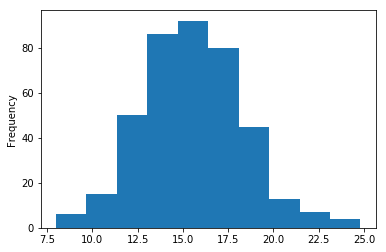

In [339]:
df['acceleration'].plot.hist()

Бачимо, що прискорення автомобілів має нормальний розподіл.

### Pie plot for numbers of cylinders

In [340]:
cylinders_labels_set = set(df['cylinders'])
cylinders_number = []

for label in cylinders_labels_set:
    cylinders_number.append(list(df['cylinders']).count(label))

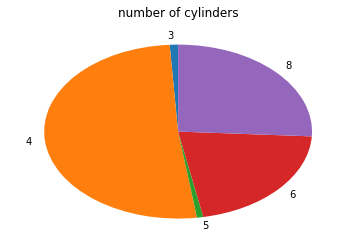

In [341]:
plt.pie(cylinders_number, labels=cylinders_labels_set, startangle=90)
plt.title('number of cylinders')
plt.show()

Найбільші частки займають 4-х та 8-ми циліндрові автомобілі

### Distribution plot for target column mpg

C:\Users\iport\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


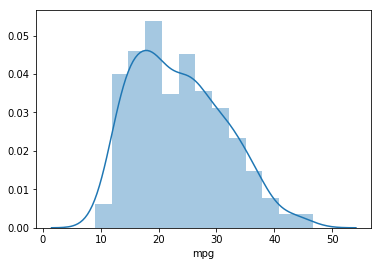

In [342]:
sb.distplot(df['mpg'])

### Pair plot

C:\Users\iport\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


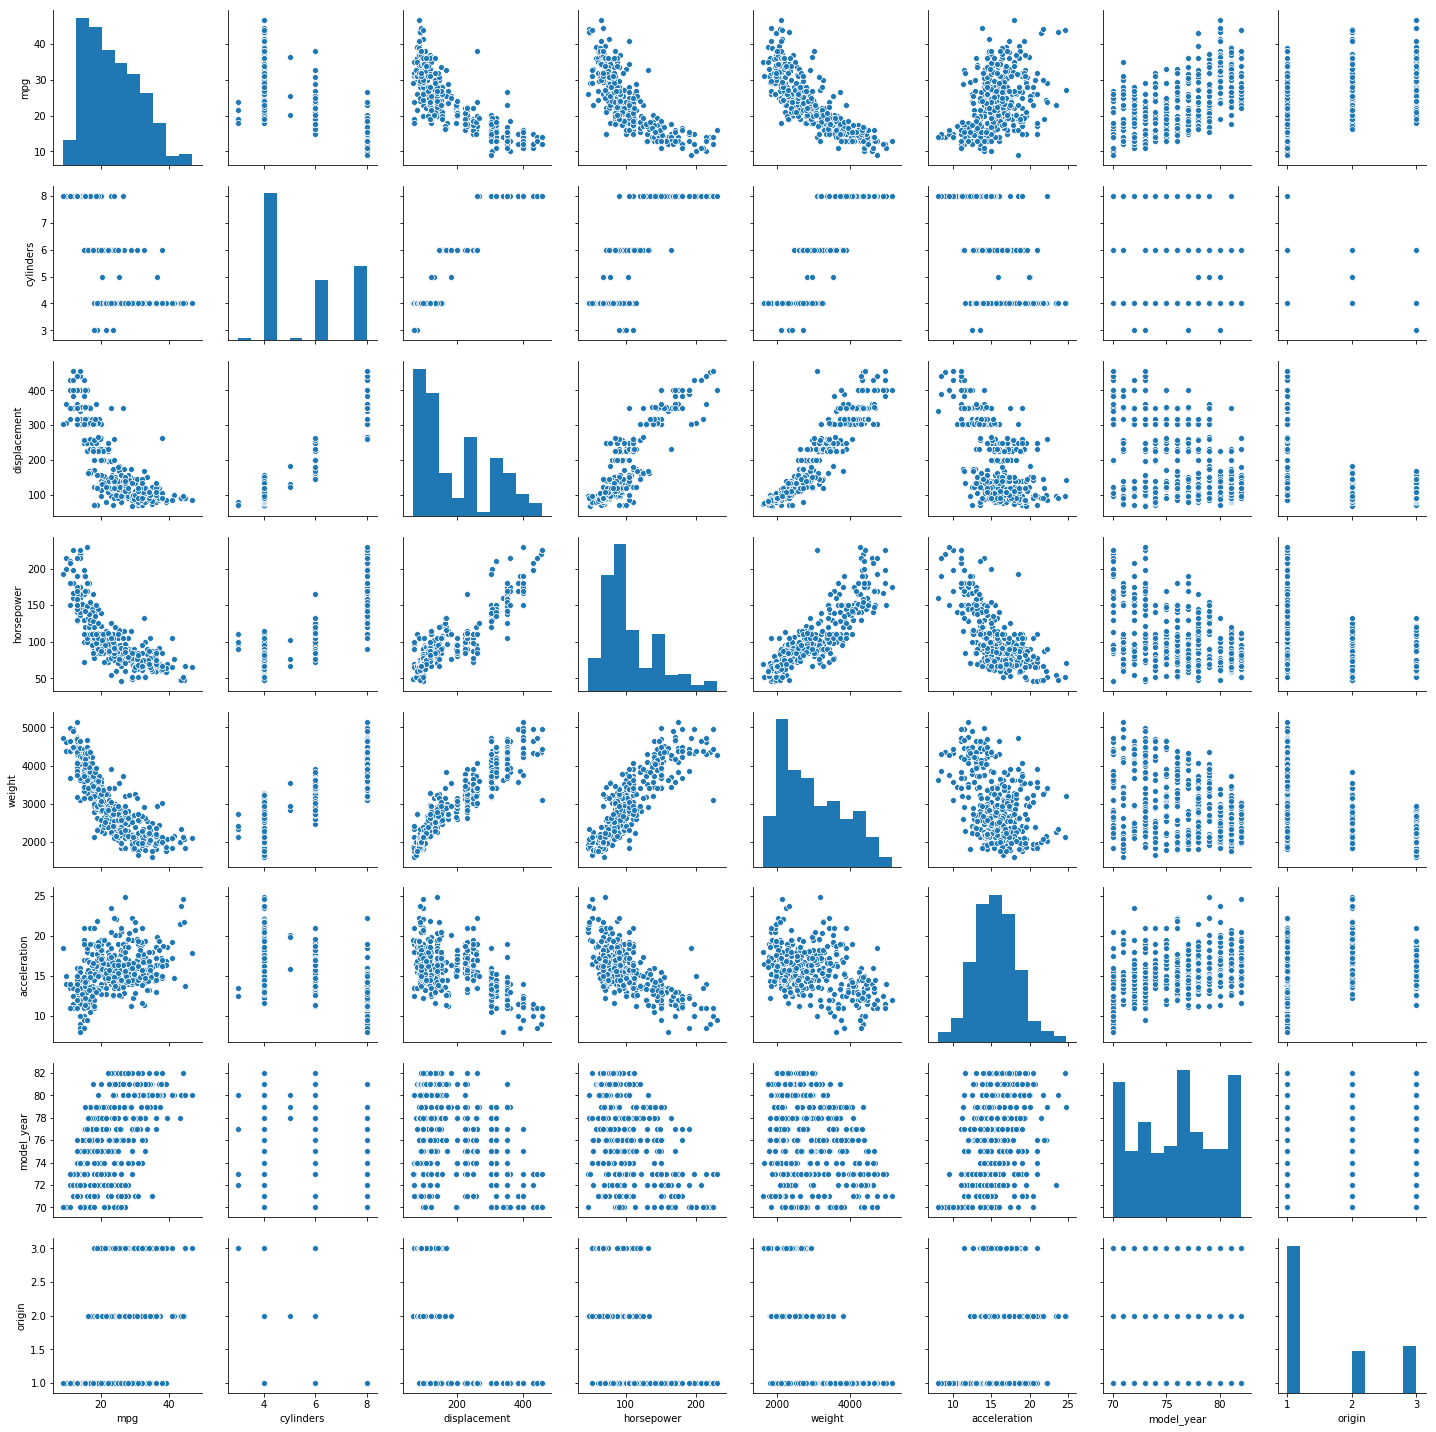

In [343]:
sb.pairplot(df, size=2.5);

### Correlation heatmap

In [344]:
def plot_correlation(data, columns):
    cm = np.corrcoef(data.T)
    plt.figure(figsize=(10,10))
    heatmap = sb.heatmap(cm, cbar=True, annot=True, square=True,
                         fmt='.2f', annot_kws={'size':10}, xticklabels=columns, yticklabels=columns)

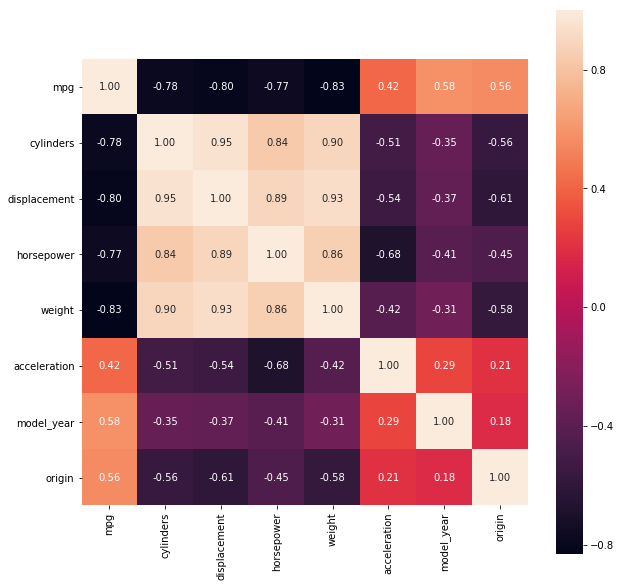

In [345]:
plot_correlation(df, columns)

## Box plots

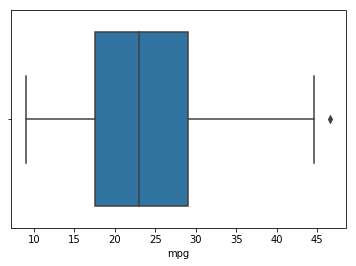

In [346]:
sb.boxplot(x=df['mpg'])

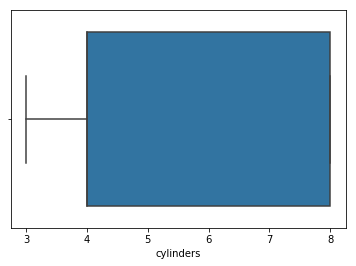

In [347]:
sb.boxplot(x=df['cylinders'])

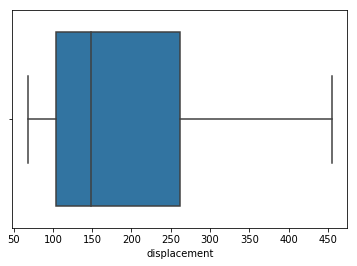

In [348]:
sb.boxplot(x=df['displacement'])

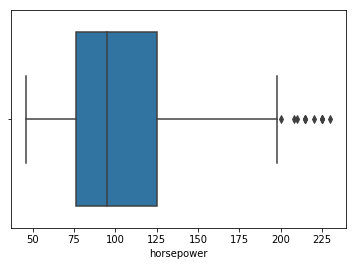

In [349]:
sb.boxplot(x=df['horsepower'])

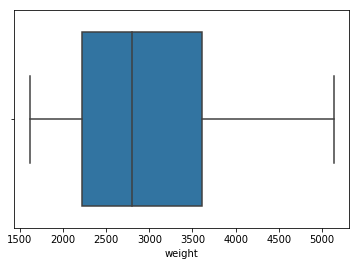

In [350]:
sb.boxplot(x=df['weight'])

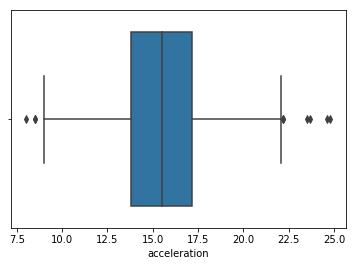

In [351]:
sb.boxplot(x=df['acceleration'])

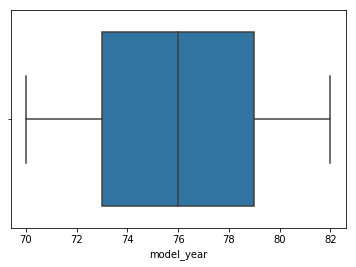

In [352]:
sb.boxplot(x=df['model_year'])

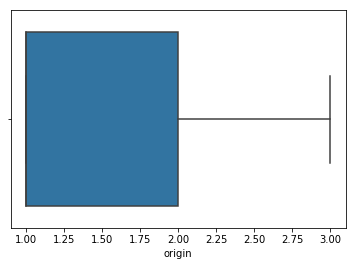

In [353]:
sb.boxplot(x=df['origin'])

Маємо викиди в колонках: mpg, horsepower, acceleration. Видалимо ці точки.

In [354]:
z = np.abs(stats.zscore(df))

In [355]:
df_without_outliers = df[(z < 3).all(axis=1)]

In [356]:
df.shape

(398, 8)

In [357]:
df_without_outliers.shape

(391, 8)

Бачимо, що викидів було небагато й їх видалено.

In [358]:
X = df_without_outliers.values[:, 1:]
y = df_without_outliers.values[:, 0]

## Scale data

In [359]:
rs = RobustScaler(with_centering=True, with_scaling=True, quantile_range=(25.0, 75.0))
X_scaled = rs.fit_transform(X)

## Train test split

In [360]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=True, random_state=0)

### Metric: r_squared

## Cross-validation

Обрано наступні моделі: LinearRegression, Lasso, ElasticNet, SGDRegressor, Ridge

In [361]:
lin_reg = LinearRegression()
lasso_reg = Lasso(alpha=0.1)
elastic_reg = ElasticNet(alpha=0.0001, l1_ratio=0)
sgd_reg = SGDRegressor(alpha=0.0001, max_iter=1000, tol=0.001, shuffle=True, epsilon=0.01, random_state=333)
ridge_reg = Ridge(alpha=0.0001)
models = [lin_reg, lasso_reg, elastic_reg, sgd_reg, ridge_reg]
titles = ['Linear Regression', 'Lasso', 'ElasticNet', 'SGDRegressor', 'Ridge']

In [362]:
print('      Model                 R-squared score')
for i in range(len(models)):
    scores = cross_val_score(models[i], X_train, y_train, cv=13, scoring='r2')
    print(f"{titles[i]:17}:    {scores.mean():10} (+/- {scores.std() * 2})")

      Model                 R-squared score
Linear Regression:    0.7850627964792272 (+/- 0.10122501082470219)
Lasso            :    0.791852618646852 (+/- 0.10141332847862508)


C:\Users\iport\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\iport\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\iport\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\iport\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coo

ElasticNet       :    0.7851250045497172 (+/- 0.10133141517743739)
SGDRegressor     :    0.7824589651624544 (+/- 0.11188216115590865)
Ridge            :    0.7850630167086101 (+/- 0.10122538146322296)


Великої різниці між моделями немає, але найкращий score на кросс-валідації в Lasso.

In [363]:
lasso_reg = Lasso(alpha=0.0001)
lasso_reg.fit(X_train, y_train)
y_pred = lasso_reg.predict(X_test)
print('Model: Lasso')
print('r-squred score:', r2_score(y_test, y_pred))

Model: Lasso
r-squred score: 0.848950086779225


Бачимо, що найкращою моделлю є Lasso. Точність не ідеальна, думаю, через те, що кількість даних не дуже велика.